# **Prerequisites**

In [3]:
!pip install -q diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 95.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.2/108.2 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.5 MB/s eta 0:00:00


In [2]:
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 20.5 MB/s eta 0:00:00


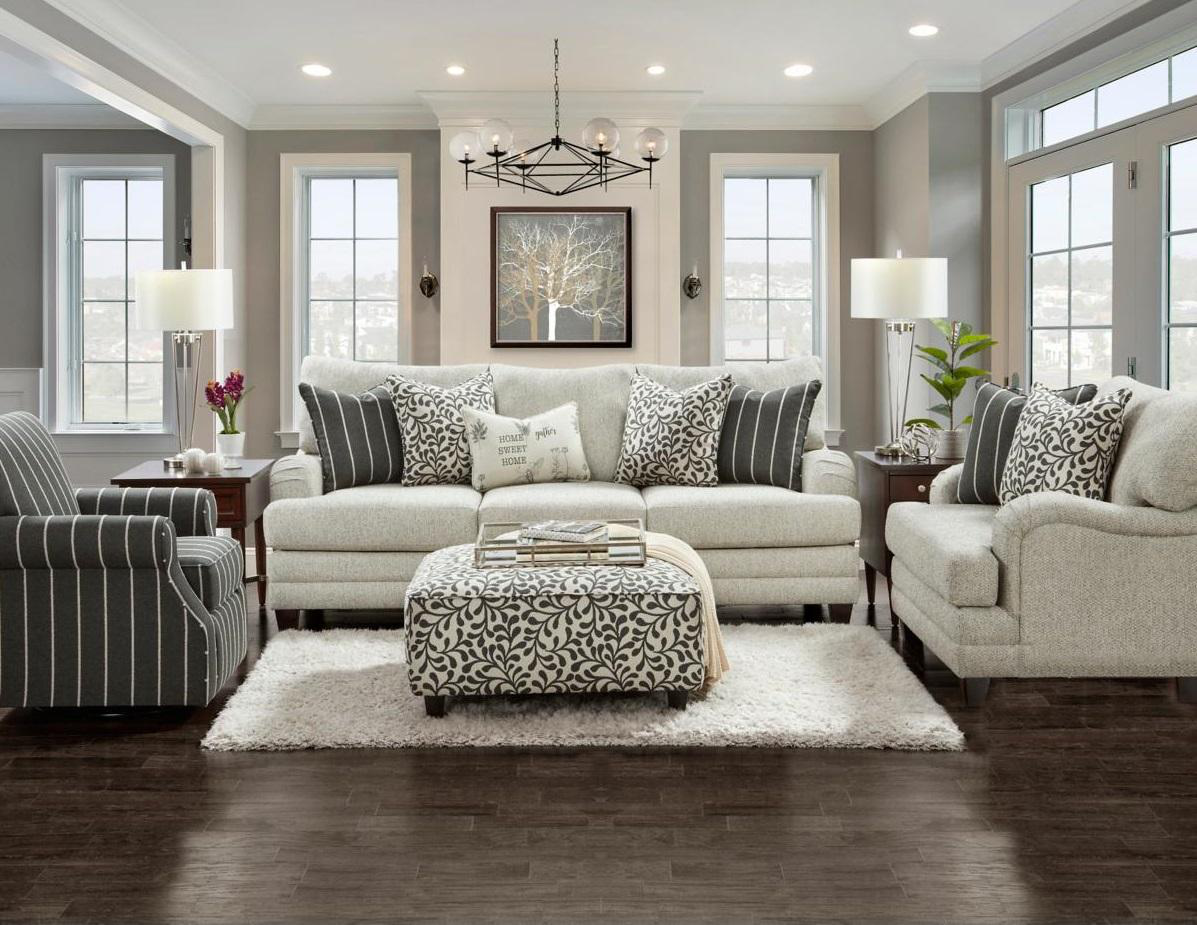

In [7]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

image = load_image(
    "https://lh6.googleusercontent.com/mMcnT3yd5I3fjV5OFCG7gi7eL8lqo7ta39S1LcTvmqnScNQZjIfUCNGnnfDPzXbW_lzz37pAKq0QVNHr66S88uK3GEvkgVK1e1ylT0M-SfJke4M0xqEHGjLbMC-zqcFm1MLPdWY"
)
image

Canny pre-processor:

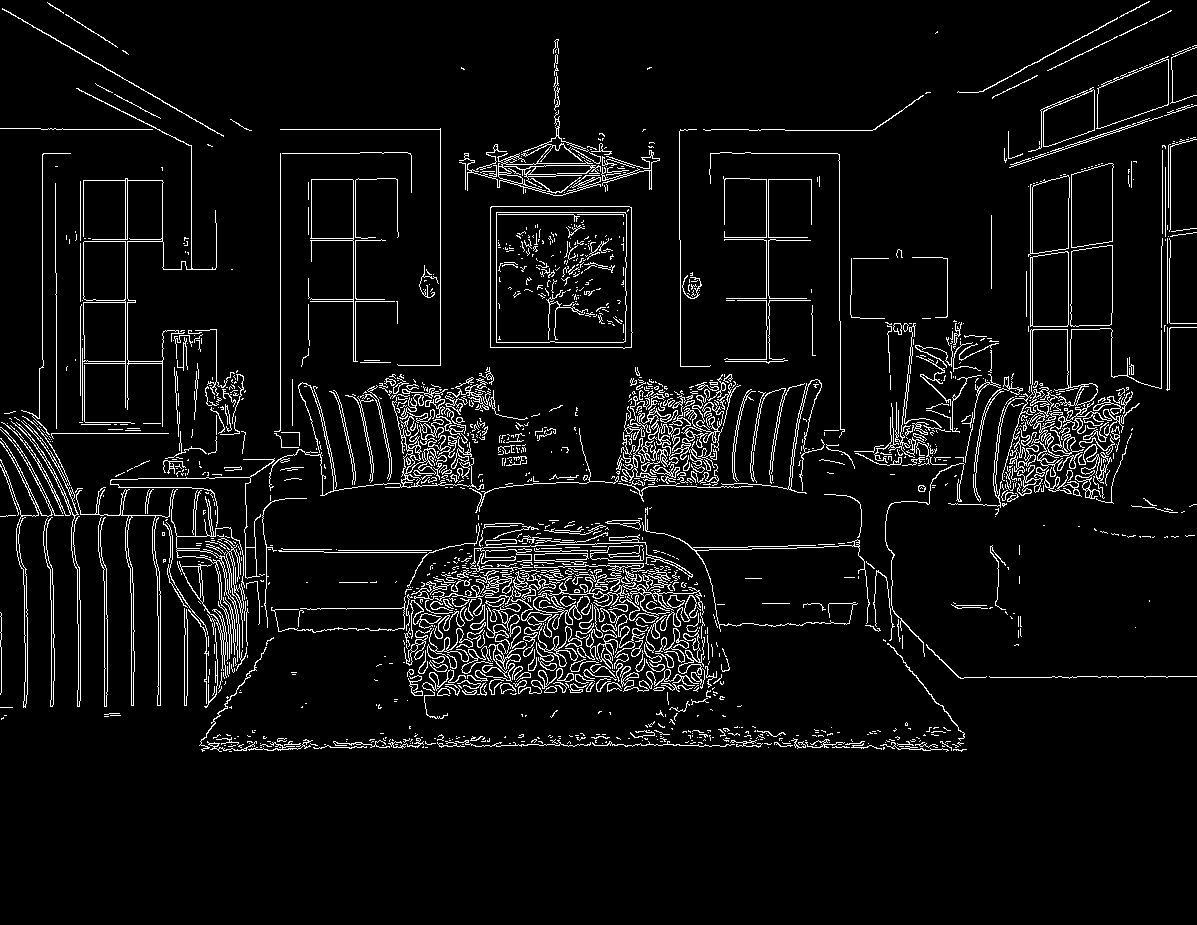

In [8]:
import cv2
from PIL import Image
import numpy as np

image = np.array(image)

low_threshold = 200
high_threshold = 250

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image

In [9]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch

from diffusers import DiffusionPipeline

#runwayml/stable-diffusion-v1-5
# pipe = DiffusionPipeline.from_pretrained("medmac01/beldimoroccaninteriour")

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "medmac01/beldi-moroccan-interior-2", controlnet=controlnet, torch_dtype=torch.float16
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

The config attributes {'addition_embed_type': None, 'addition_embed_type_num_heads': 64, 'class_embeddings_concat': False, 'cross_attention_norm': None, 'encoder_hid_dim': None, 'mid_block_only_cross_attention': None, 'resnet_out_scale_factor': 1.0, 'resnet_skip_time_act': False, 'time_embedding_act_fn': None, 'time_embedding_dim': None} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [10]:
from diffusers import UniPCMultistepScheduler

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

In [11]:
pipe.enable_model_cpu_offload()

In [12]:
pipe.enable_xformers_memory_efficient_attention()

  0%|          | 0/20 [00:00<?, ?it/s]

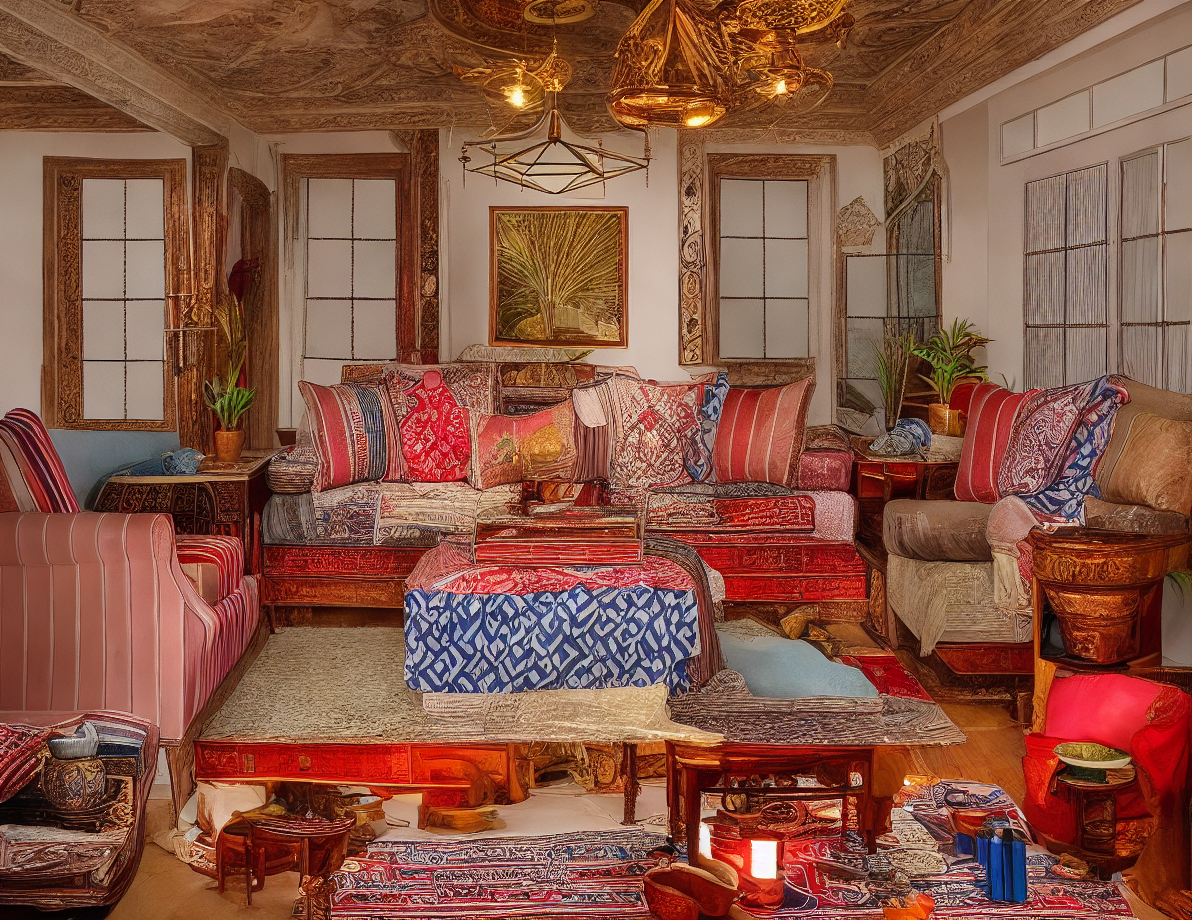

In [13]:
prompt = "beldi moroccan home interior for a living room, minimal"
# prompt = [prompt for t in [""*4]]
# generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(len(prompt))]

output = pipe(
    prompt,
    canny_image,
    negative_prompt="modern design, monochrome, lowres, bad anatomy, worst quality, low quality",
    num_inference_steps=20,
)

output.images[0]

In [ ]:
output.images[0]

In [ ]:
pipe.save_pretrained("my-ctrlnet")

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [17]:
# Code to upload a pipeline saved locally to the hub
from huggingface_hub import HfApi, ModelCard, create_repo, get_full_repo_name

# Set up repo and upload files
hub_model_id = 'medmac01/moroccaninteriour-controlNet'
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(folder_path="my-ctrlnet", path_in_repo="", repo_id=hub_model_id)

content = f"""

"""

card = ModelCard(content)
hub_url = card.push_to_hub(hub_model_id)
print(f"Upload successful! Model can be found here: {hub_url}")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 6>:6                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_validators.py:120 in _inner_fn    │
│                                                                                                  │
│   117 │   │   if check_use_auth_token:                                                           │
│   118 │   │   │   kwargs = smoothly_deprecate_use_auth_token(fn_name=fn.__name__, has_token=ha   │
│   119 │   │                                                                                      │
│ ❱ 120 │   │   return fn(*args, **kwargs)                                                         │
│   121 │                                                                                          │
│   122 │   return _inner_fn  # type: ignore                                                       │
│   123                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/huggingface_hub/hf_api.py:2181 in create_repo            │
│                                                                                                  │
│   2178 │   │   │   # Testing purposes only.                                                      │
│   2179 │   │   │   # See https://github.com/huggingface/huggingface_hub/pull/733/files#r8206044  │
│   2180 │   │   │   json["lfsmultipartthresh"] = self._lfsmultipartthresh  # type: ignore         │
│ ❱ 2181 │   │   headers = self._build_hf_headers(token=token, is_write_action=True)               │
│   2182 │   │   r = get_session().post(path, headers=headers, json=json)                          │
│   2183 │   │                                                                                     │
│   2184 │   │   try:                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/huggingface_hub/hf_api.py:4732 in _build_hf_headers      │
│                                                                                                  │
│   4729 │   │   if token is None:                                                                 │
│   4730 │   │   │   # Cannot do `token = token or self.token` as token can be `False`.            │
│   4731 │   │   │   token = self.token                                                            │
│ ❱ 4732 │   │   return build_hf_headers(                                                          │
│   4733 │   │   │   token=token,                                                                  │
│   4734 │   │   │   is_write_action=is_write_action,                                              │
│   4735 │   │   │   library_name=library_name or self.library_name,                               │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_validators.py:120 in _inner_fn    │
│                                                                                                  │
│   117 │   │   if check_use_auth_token:                                                           │
│   118 │   │   │   kwargs = smoothly_deprecate_use_auth_token(fn_name=fn.__name__, has_token=ha   │
│   119 │   │                                                                                      │
│ ❱ 120 │   │   return fn(*args, **kwargs)                                                         │
│   121 │                                                    

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 6>:6                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_validators.py:120 in _inner_fn    │
│                                                                                                  │
│   117 │   │   if check_use_auth_token:                                                           │
│   118 │   │   │   kwargs = smoothly_deprecate_use_auth_token(fn_name=fn.__name__, has_token=ha   │
│   119 │   │                                                                                      │
│ ❱ 120 │   │   return fn(*args, **kwargs)                                                         │
│   121 │                                                                                          │
│   122 │   return _inner_fn  # type: ignore                                                       │
│   123                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/huggingface_hub/hf_api.py:2181 in create_repo            │
│                                                                                                  │
│   2178 │   │   │   # Testing purposes only.                                                      │
│   2179 │   │   │   # See https://github.com/huggingface/huggingface_hub/pull/733/files#r8206044  │
│   2180 │   │   │   json["lfsmultipartthresh"] = self._lfsmultipartthresh  # type: ignore         │
│ ❱ 2181 │   │   headers = self._build_hf_headers(token=token, is_write_action=True)               │
│   2182 │   │   r = get_session().post(path, headers=headers, json=json)                          │
│   2183 │   │                                                                                     │
│   2184 │   │   try:                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/huggingface_hub/hf_api.py:4732 in _build_hf_headers      │
│                                                                                                  │
│   4729 │   │   if token is None:                                                                 │
│   4730 │   │   │   # Cannot do `token = token or self.token` as token can be `False`.            │
│   4731 │   │   │   token = self.token                                                            │
│ ❱ 4732 │   │   return build_hf_headers(                                                          │
│   4733 │   │   │   token=token,                                                                  │
│   4734 │   │   │   is_write_action=is_write_action,                                              │
│   4735 │   │   │   library_name=library_name or self.library_name,                               │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_validators.py:120 in _inner_fn    │
│                                                                                                  │
│   117 │   │   if check_use_auth_token:                                                           │
│   118 │   │   │   kwargs = smoothly_deprecate_use_auth_token(fn_name=fn.__name__, has_token=ha   │
│   119 │   │                                                                                      │
│ ❱ 120 │   │   return fn(*args, **kwargs)                                                         │
│   121 │                                                    